$$数据预处理$$

In [252]:
import random
import math
from copy import deepcopy
import matplotlib.pyplot as plt
import time

In [253]:
#加上with可以自动关闭文件。
with open('flowshop-test-10-student.txt','r') as f:
    #open为打开文件，r为读取
    f = open('flowshop-test-10-student.txt','r')
    #逐行读取文件内容
    lines = f.readlines()
    #print(lines)


In [254]:
sents = []
#遍历lines
for line in lines:
    #消除空格和空行
    line = line.strip()
    tokens = line.split(',')
    for token in tokens:
        if len(token) > 0:
            sents.append(token)
print(sents)
print(type(sents[0]))

['+++++++++++++++++++++++++++++', 'instance 0', '11 5', '0 375 1  12 2 142 3 245 4 412', '0 632 1 452 2 758 3 278 4 398', '0  12 1 876 2 124 3 534 4 765', '0 460 1 542 2 523 3 120 4 499', '0 528 1 101 2 789 3 124 4 999', '0 796 1 245 2 632 3 375 4 123', '0 532 1 230 2 543 3 896 4 452', '0  14 1 124 2 214 3 543 4 785', '0 257 1 527 2 753 3 210 4 463', '0 896 1 896 2 214 3 258 4 259', '0 532 1 302 2 501 3 765 4 988', '+++++++++++++++++++++++++++++', 'instance 1', '8 8', '0 456 1 654 2 852 3 145 4 632 5 425 6 214 7 654', '0 789 1 123 2 369 3 678 4 581 5 396 6 123 7 789', '0 654 1 123 2 632 3 965 4 475 5 325 6 456 7 654', '0 321 1 456 2 581 3 421 4  32 5 147 6 789 7 123', '0 456 1 789 2 472 3 365 4 536 5 852 6 654 7 123', '0 789 1 654 2 586 3 824 4 325 5  12 6 321 7 456', '0 654 1 321 2 320 3 758 4 863 5 452 6 456 7 789', '0 789 1 147 2 120 3 639 4  21 5 863 6 789 7 654', '+++++++++++++++++++++++++++++', 'instance 2', '13 4', '0 654 1 147 2 345 3 447', '0 321 1 520 2 789 3 702', '0  12 1 1

In [255]:
info, workpiece_num, machine_num= [], [], [] #info[i]代表第i + 1个样例中的概述信息, workpiece_num[i]代表第i + 1个样例中工件数量, machine_num代表第i + 1个样例中机器数量
count = 0

for i in range(len(sents)):
    if(sents[i] == '+++++++++++++++++++++++++++++'):
        info.append(sents[i + 2])
        count += 1
        x, y = map(int, info[count-1].split())
        workpiece_num.append(x)
        machine_num.append(y)
        if (count == 11):
            break
            
            
for i in range(11):
    print(f"instance {i}:{info[i]}||{workpiece_num[i]},{machine_num[i]}")

instance 0:11 5||11,5
instance 1:8 8||8,8
instance 2:13 4||13,4
instance 3:12 5||12,5
instance 4:14 4||14,4
instance 5:10 6||10,6
instance 6:20 10||20,10
instance 7:20 15||20,15
instance 8:20  5||20,5
instance 9:20 15||20,15
instance 10:50 10||50,10


In [256]:
input_data = [[] for i in range(11)]
count = 0

for i in range(len(sents)):
    if(sents[i] == '+++++++++++++++++++++++++++++'):
        data_temp = []
        for j in range(workpiece_num[count]):
            temp = sents[i + 3 + j]
            lst = list(map(int, temp.split()))
            lst = lst[1::2]
            data_temp.append(lst)
        input_data[count] = data_temp
        count += 1
        if(count == 11):
            break
print("整理好的三维数据列表input_data中包含的11个二维列表的行数:")
for i in range(11):
    print(len(input_data[i]),end=' ')
print("\n")
print("打印三维数据列表input_data中存储的第一个二维列表：")
print(input_data[0])
print("需要提取第i个例子中，第j个零件在第k台机器上加工的时间，直接在三维列表input_data上使用索引即可访问\n例如，提取了第1个例子中，第3个零件在第5台机器上的加工时间：")
print(input_data[0][2][4])
# input = input_data[0]
# print(len(input[0]))

整理好的三维数据列表input_data中包含的11个二维列表的行数:
11 8 13 12 14 10 20 20 20 20 50 

打印三维数据列表input_data中存储的第一个二维列表：
[[375, 12, 142, 245, 412], [632, 452, 758, 278, 398], [12, 876, 124, 534, 765], [460, 542, 523, 120, 499], [528, 101, 789, 124, 999], [796, 245, 632, 375, 123], [532, 230, 543, 896, 452], [14, 124, 214, 543, 785], [257, 527, 753, 210, 463], [896, 896, 214, 258, 259], [532, 302, 501, 765, 988]]
需要提取第i个例子中，第j个零件在第k台机器上加工的时间，直接在三维列表input_data上使用索引即可访问
例如，提取了第1个例子中，第3个零件在第5台机器上的加工时间：
765


$$定义FLOW-SHOP问题的时间计算函数$$

In [257]:
def flow_shop(input, schedule): #定义FLOW-SHOP问题的时间计算函数
    n = len(input)  # 工件数量n
    m = len(input[0])  # 机器数量m
    time = [[0 for j in range(m)] for i in range(n)]
    time[0][0] = input[schedule[0]][0]
    for j in range(1, m):
        time[0][j] = time[0][j-1] + input[schedule[0]][j]
    for i in range(1, n):
        time[i][0] = time[i-1][0] + input[schedule[i]][0]
    for i in range(1, n):
        for j in range(1, m):
            time[i][j] = max(time[i-1][j], time[i][j-1]) + input[schedule[i]][j]
    return time[n-1][m-1]


# 示例
input = [[1, 2, 3], [4, 2, 1], [5, 1, 3]]
schedule_instance = [i for i in range(3)]
print(flow_shop(input, schedule_instance))


14


$$模拟退火算法$$

定义爬山算法生成子空间方法

In [258]:
def Exchange_order(lst):#定义爬山算法生成子空间方法
    n = len(lst)
    i, j = random.sample(range(n), 2)
    lst[i], lst[j] = lst[j], lst[i] #随机生成两个索引并交换位置

定义爬山算法中的单步操作

In [259]:
def climbing_algorithm_step(input, current_solution):#定义爬山算法单步操作
    new_solutions = []
    solutions_time = []
    for i in range(10):
        new_solutions.append(deepcopy(current_solution))
        Exchange_order(new_solutions[i])  # 随机选择两个零件进行加工顺序位置交换，生成临近解空间
        solutions_time.append(flow_shop(input, new_solutions[i]))
    min_time = min(solutions_time)
    min_index = solutions_time.index(min_time)
    new_solution = new_solutions[min_index]  #使用最陡爬山法，每次选择临近解空间中的最优项
    return new_solution


定义爬山算法

In [260]:
def climbing_algorithm(input):
    makespan = []
    current_solution = [i for i in range(len(input))] #生成初始解
    makespan.append(flow_shop(input, current_solution)) 
    new_solution = climbing_algorithm_step(input, current_solution)
    while(flow_shop(input, new_solution) < flow_shop(input, current_solution)): #若“临近点集”中所有点都等于或低于当前所在位置点高度，则认为找到了“山顶”，爬山算法结束
        current_solution = new_solution
        makespan.append(flow_shop(input, current_solution))
        new_solution = climbing_algorithm_step(input, current_solution)
    best_solution = current_solution
    return makespan, best_solution


测试爬山算法

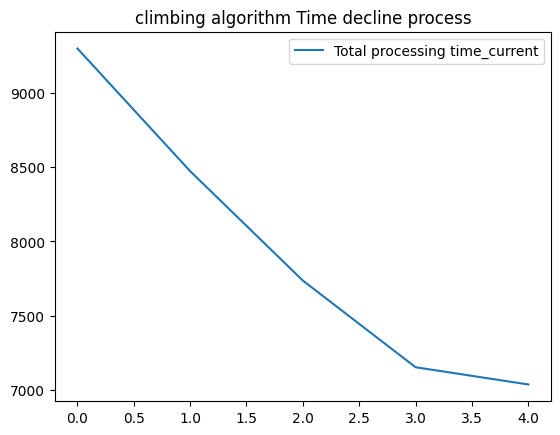

instance 0 's best soltion time is 7038
instance 0 's best soltion schedule is [7, 0, 2, 10, 4, 3, 6, 1, 8, 9, 5]
运行时间: 0.003000497817993164 秒


In [261]:
i_0 = 0 #通过修改此值调整输入的instance是哪一个，i_0 = 0说明输入instance 0
input_instance = input_data[i_0]
start_time = time.time()
makespan, best_solution = climbing_algorithm(input_instance)
end_time = time.time()
plt.plot(makespan, label = "Total processing time_current") #使用matplotlib进行图表绘制和可视化
plt.legend()
plt.title("climbing algorithm Time decline process")
plt.show()
print(f"instance {i_0} 's best soltion time is {flow_shop(input_instance, best_solution)}")
print(f"instance {i_0} 's best soltion schedule is {best_solution}")
print(f"运行时间: {end_time - start_time} 秒")

定义基于模拟退火算法的爬山算法

In [262]:
def simulated_annealing(input, temp=1000, cooling_rate=0.00075, ending_temp=1):
    current_solution = [i for i in range(len(input))] #生成初始解
    best_solution = deepcopy(current_solution)
    current_time_var, best_time_var = [],[]
    current_time_var.append(flow_shop(input, best_solution))
    while temp > ending_temp:
        new_solution = climbing_algorithm_step(input, current_solution) #每步爬山
        current_energy = flow_shop(input, current_solution) 
        new_energy = flow_shop(input, new_solution)
        if (new_energy < current_energy): #比较新解和当前解，若新解优于当前解则使用新解更新当前解
            current_solution = new_solution
        else:
            if math.exp((current_energy - new_energy) / temp) > random.random():
                current_solution = new_solution   #math.exp((current_energy - new_energy) / temp)。其中 current_energy 是当前解决方案的能量，
                                            #new_energy 是新解决方案的能量，temp 是当前温度。随着温度的降低，接受劣质解决方案的概率也会降低。
        if flow_shop(input, current_solution) < flow_shop(input, best_solution):
            best_solution = current_solution
        current_time_var.append(flow_shop(input, current_solution))
        best_time_var.append(flow_shop(input, best_solution))
        temp *= 1 - cooling_rate    #降低温度，以便在搜索过程中逐渐减少接受劣质解决方案的概率(TEMP越大，退火速度越快，接受局部最优解概率越大)
    
    return current_time_var, best_time_var, best_solution

测试基于模拟退火算法的爬山算法

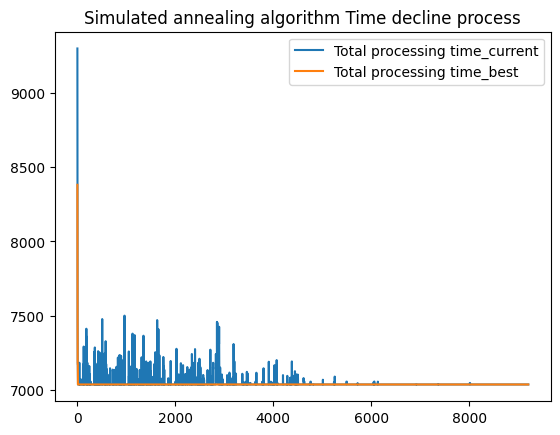

instance 0 's best soltion time is 7038
instance 0 's best soltion schedule is [7, 2, 4, 1, 0, 10, 3, 8, 6, 9, 5]
运行时间: 3.9839019775390625 秒


In [263]:
i_1 = 0
input_instance = input_data[i_1]
start_time = time.time()
current_time_var, best_time_var, best_solution = simulated_annealing(input_instance)
end_time = time.time()
plt.plot(current_time_var, label = "Total processing time_current")
plt.plot(best_time_var, label = "Total processing time_best")
plt.legend()
plt.title("Simulated annealing algorithm Time decline process")
plt.show()
print(f"instance {i_1} 's best soltion time is {flow_shop(input_instance, best_solution)}")
print(f"instance {i_1} 's best soltion schedule is {best_solution}")
print(f"运行时间: {end_time - start_time} 秒")

$$遗传算法$$

定义遗传算法的适应度函数

In [264]:
def cal_fitness(population, process_time_input):
    fitness = []
    for individual in population:
        time_count = flow_shop(process_time_input, individual)
        fitness.append(1 / time_count)
    return fitness

定义遗传算法选择方式

In [265]:
def selection(fitness, population): #定义遗传算法选择方式，这里选择使用轮盘赌选择进行子代选择
    fitness_sum = []
    for i in range(len(fitness)):
        if i == 0:
            fitness_sum.append(fitness[i])
        else:
            fitness_sum.append(fitness_sum[i-1] + fitness[i]) #依据子代的不同适应度生成不同的选择区间，适应度越大，对应的选择区间就越长，被选择概率越高
    for i in range(len(fitness_sum)):
        fitness_sum[i] /= sum(fitness) 
    new_population = []
    for i in range(len(population)): 
        rand = random.random()    #生成随机数并判断落在哪一区间，选择相应子代
        for j in range(len(fitness_sum)):
            if j == 0:
                if rand <= fitness_sum[j]:
                    new_population.append(population[j])
                    break
            else:
                if rand <= fitness_sum[j] and rand > fitness_sum[j-1]:
                    new_population.append(population[j])
                    break
    return new_population


定义遗传算法交叉方式

In [266]:
# def crossover(parent1, parent2): #单点交叉算子交叉方法
#     index1 = random.randint(0, len(parent1)-2)
#     index2 = random.randint(index1, len(parent1)-1)
#     temp_child1 = parent1[index1:index2]
#     temp_child2 = [item for item in parent2 if item not in temp_child1]
#     child = temp_child2[:index1] + temp_child1 + temp_child2[index1:]
#     return child

In [267]:
def crossover(parent1, parent2): #改进的单点交叉算子交叉方法
    index = random.randint(0, len(parent1)-1)
    rand = random.random()#首先随机产生一交叉点；然后产生一个随机数(rand)，确定交叉段的保留部分
    if rand <= 0.5:#当rand小于等于0.5时，把两父代交叉点后的基因复制给两子代，然后从父代2（或1）中找出子代1（或2）中缺失的基因，并将其按顺序复制给两子代交叉点前的位置
        temp_child1 = parent1[index:]
        temp_child2 = [item for item in parent2 if item not in temp_child1]
        child = temp_child2 + temp_child1
    else:#当rand大于0.5时，把两父代交叉点前的基因复制给子代，然后从父代2（或1）中找出子代1（或2）中缺失的基因，并将其按顺序复制给两子代交叉点后的位置
        temp_child1 = parent1[:index]
        temp_child2 = [item for item in parent2 if item not in temp_child1]
        child = temp_child1 + temp_child2
    return child


定义遗传算法变异方式

In [268]:
def mutation(child, mutation_rate):#与前文中提到的单步爬山中生成临近解空间的方法类似，变异方法为：随机选择两个点并交换顺序
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(child)), 2)
        child[i], child[j] = child[j], child[i]
    return child

定义遗传算法主函数

In [269]:
def genetic_algorithm(input, population_size, elite_size, max_gen, crossover_rate, mutation_rate):
    population = []
    for i in range(population_size):
        population.append(random.sample(range(len(input)), len(input))) #生成初始种群
    current_makespan, current_solutions, best_makespan, best_solutions= [], [], [], [] 
    
    for gen in range(max_gen):
        fitness = cal_fitness(population, input) #计算种群中每个个体适应度
        
        best_index = fitness.index(max(fitness))
        
        current_makespan.append(1/fitness[best_index])
        current_solution = population[best_index]  #选择种群中适应度最优个体作为该代中最优解
        if(gen == 0):
            best_solutions.append(current_solution)
            best_makespan.append(1/fitness[best_index])
        else:
            if 1/fitness[best_index] < min(best_makespan):
                best_makespan.append(1/fitness[best_index])
                best_solutions.append(current_solution)
            else:
                best_makespan.append(best_makespan[gen-1])
                best_solutions.append(best_solutions[gen-1])
        current_solutions.append(current_solution)
        population = selection(fitness, population) #选择操作
        
        
        new_population = []
        for i in range(elite_size):
            new_population.append(population.pop(population.index(max(population)))) #进行精英种群筛选
        
        while len(new_population) < population_size: #交叉操作
            if random.random() < crossover_rate:
                parent1 = population[random.randint(0,len(population)-1)]
                parent2 = population[random.randint(0,len(population)-1)]
                child = crossover(parent1, parent2)
            else:
                child = population[random.randint(0,len(population)-1)]
            mutation(child, mutation_rate) #变异操作
            
            new_population.append(child)
        population = new_population
    
    return current_makespan, current_solutions, best_makespan, best_solutions

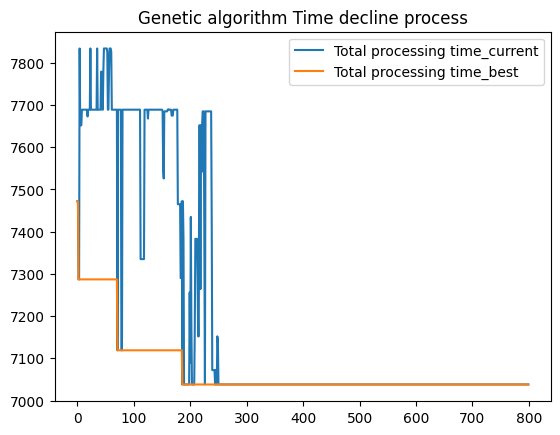

instance 0 's best soltion time is 7038
instance 0 's best soltion time is 7038.0
instance 0 's best soltion schedule is [7, 2, 0, 4, 8, 10, 1, 6, 3, 9, 5]
运行时间: 4.968653917312622 秒


In [270]:
i_2 = 0
input_instance = input_data[i_2]

population_size = 200  #种群大小
elite_size = int(0.2 * population_size)  #精英个体数量
max_gen = 800 #最大遗传代数
crossover_rate = 0.8 #交叉率
mutation_rate = 0.03 #变异率

start_time = time.time()
current_makespan, current_solutions, best_makespan, best_solutions= genetic_algorithm(input=input_instance,
                   population_size=population_size,
                   elite_size=elite_size,
                   max_gen=max_gen,
                   crossover_rate=crossover_rate,
                   mutation_rate=mutation_rate)
end_time = time.time()
plt.plot(current_makespan, label = "Total processing time_current")
plt.plot(best_makespan, label = "Total processing time_best")
plt.legend()
plt.title("Genetic algorithm Time decline process")
plt.show()
print(f"instance {i_2} 's best soltion time is {flow_shop(input_instance, best_solutions[-1])}")
print(f"instance {i_2} 's best soltion time is {best_makespan[-1]}")
print(f"instance {i_2} 's best soltion schedule is {best_solutions[-1]}")
print(f"运行时间: {end_time - start_time} 秒")


内嵌爬山算法的改进遗传算法

In [271]:
def genetic_algorithm(input, population_size, elite_size, max_gen, crossover_rate, mutation_rate): #改进的遗传算法代码与遗传算法代码基本相同，仅仅在变异操作后嵌入了爬山算法优化
    population = []
    for i in range(population_size):
        population.append(random.sample(range(len(input)), len(input)))
    current_makespan, current_solutions, best_makespan, best_solutions= [], [], [], []
    
    for gen in range(max_gen):
        fitness = cal_fitness(population, input)
        
        best_index = fitness.index(max(fitness))
        
        current_makespan.append(1/fitness[best_index])
        current_solution = population[best_index]
        if(gen == 0):
            best_solutions.append(current_solution)
            best_makespan.append(1/fitness[best_index])
        else:
            if 1/fitness[best_index] < min(best_makespan):
                best_makespan.append(1/fitness[best_index])
                best_solutions.append(current_solution)
            else:
                best_makespan.append(best_makespan[gen-1])
                best_solutions.append(best_solutions[gen-1])
        current_solutions.append(current_solution)
        population = selection(fitness, population)
        
        
        new_population = []
        for i in range(elite_size):
            new_population.append(population.pop(population.index(max(population))))
        
        while len(new_population) < population_size:
            if random.random() < crossover_rate:
                parent1 = population[random.randint(0,len(population)-1)]
                parent2 = population[random.randint(0,len(population)-1)]
                child = crossover(parent1, parent2)
            else:
                child = population[random.randint(0,len(population)-1)]
            mutation(child, mutation_rate)
            
            new_child = climbing_algorithm_step(input, child)     #内嵌爬山算法优化子代
            if flow_shop(input, new_child) < flow_shop(input, child):
                child = new_child
            
            new_population.append(child)
        population = new_population
    
    return current_makespan, current_solutions, best_makespan, best_solutions

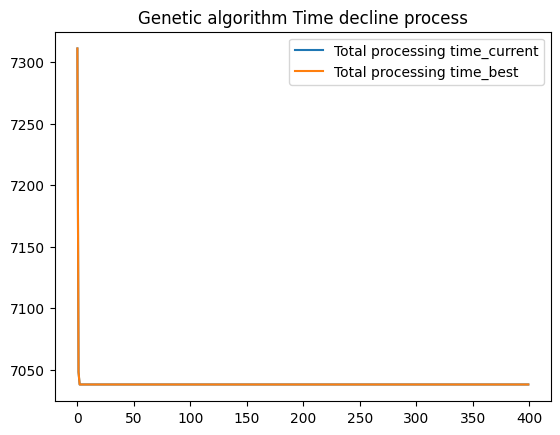

instance 0 's best soltion time is 7038
instance 0 's best soltion time is 7038.0
instance 0 's best soltion schedule is [7, 2, 4, 1, 0, 10, 6, 8, 9, 5, 3]
运行时间: 24.146750450134277 秒


In [272]:
i_3 = 0
input_instance = input_data[i_3]

population_size = 200  
elite_size = int(0.2 * population_size) 
max_gen = 400
crossover_rate = 0.8
mutation_rate = 0.03

start_time = time.time()
current_makespan, current_solutions, best_makespan, best_solutions= genetic_algorithm(input=input_instance,
                   population_size=population_size,
                   elite_size=elite_size,
                   max_gen=max_gen,
                   crossover_rate=crossover_rate,
                   mutation_rate=mutation_rate)
end_time = time.time()
plt.plot(current_makespan, label = "Total processing time_current")
plt.plot(best_makespan, label = "Total processing time_best")
plt.legend()
plt.title("Genetic algorithm Time decline process")
plt.show()
print(f"instance {i_3} 's best soltion time is {flow_shop(input_instance, best_solutions[-1])}")
print(f"instance {i_3} 's best soltion time is {best_makespan[-1]}")
print(f"instance {i_3} 's best soltion schedule is {best_solutions[-1]}")
print(f"运行时间: {end_time - start_time} 秒")

最终选择基于模拟退火算法的爬山算法运行所有样例并得到flow-shop调度用时, 并打印结果

In [273]:
for i_4 in range(0,11): #最终选择基于模拟退火算法的爬山算法运行所有样例并得到flow-shop调度用时, 并打印结果
    input_instance = input_data[i_4]
    current_time_var, best_time_var, best_solution = simulated_annealing(input_instance)
    print(f"instance {i_4} 's best soltion time is {flow_shop(input_instance, best_solution)}")
    print(f"instance {i_4} 's best soltion schedule is {best_solution}")
    print("\n")


instance 0 's best soltion time is 7038
instance 0 's best soltion schedule is [7, 0, 2, 10, 8, 6, 4, 3, 1, 9, 5]


instance 1 's best soltion time is 8366
instance 1 's best soltion schedule is [6, 2, 7, 4, 1, 0, 5, 3]


instance 2 's best soltion time is 7166
instance 2 's best soltion schedule is [6, 2, 3, 10, 12, 8, 7, 1, 5, 11, 4, 0, 9]


instance 3 's best soltion time is 7312
instance 3 's best soltion schedule is [10, 11, 5, 4, 9, 2, 8, 1, 3, 6, 7, 0]


instance 4 's best soltion time is 8003
instance 4 's best soltion schedule is [3, 13, 6, 12, 0, 7, 9, 1, 11, 8, 5, 2, 4, 10]


instance 5 's best soltion time is 7720
instance 5 's best soltion schedule is [3, 4, 1, 0, 2, 7, 5, 9, 8, 6]


instance 6 's best soltion time is 1449
instance 6 's best soltion schedule is [13, 11, 15, 18, 10, 8, 0, 9, 2, 1, 19, 3, 12, 7, 6, 4, 17, 14, 16, 5]


instance 7 's best soltion time is 1976
instance 7 's best soltion schedule is [11, 14, 5, 18, 8, 13, 4, 10, 16, 12, 1, 19, 2, 0, 7, 17, 15, 9